In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
scripts_path = os.path.abspath(os.path.join('../scripts'))
if scripts_path not in sys.path:
    sys.path.insert(0,scripts_path)

In [3]:
from station_location import *

In [4]:
X_train = pd.read_csv('../processed-data/X_train.csv', index_col=0).values
X_test = pd.read_csv('../processed-data/X_test.csv', index_col=0).values
y_train = pd.read_csv('../processed-data/y_train.csv', index_col=0).values.reshape(-1,)
y_test = pd.read_csv('../processed-data/y_test.csv', index_col=0).values.reshape(-1,)

In [5]:
X_train.shape

(239259, 7)

In [6]:
y_train.shape

(239259,)

In [22]:
X_test.shape

(59815, 7)

In [23]:
y_test.shape

(59815,)

In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [13]:
def show_accuracy(pred, true, set_):
    print(f"Predicted earthquakes: {pred[pred==1].shape[0]}")
    print(f"{set_} Accuracy: {accuracy_score(true, pred)}")
    print(f"{set_} Precision: {precision_score(true, pred)}")
    print(f"{set_} Recall: {recall_score(true, pred)}")
    print(f"{set_} F1 score: {f1_score(true, pred)}")

In [111]:
def predict(model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    show_accuracy(pred_train, y_train, "Train")
    print("")
    show_accuracy(pred_test, y_test, "Test") 

In [74]:
rfc = RandomForestClassifier(n_estimators=50, class_weight={0: 0.000001, 1: 0.999999}, n_jobs=8)
rfc.fit(X_train, y_train)
predict(rfc)

 Predicted earthquakes: 1123
Train Accuracy: 0.99987879243832
Train Precision: 1.0
Train Recall: 0.9748263888888888
Train F1 score: 0.9872527472527473
 Predicted earthquakes: 8
Test Accuracy: 0.9941653431413525
Test Precision: 0.125
Test Recall: 0.0029154518950437317
Test F1 score: 0.005698005698005698


In [77]:
gbt = GradientBoostingClassifier(n_estimators=500)
gbt.fit(X_train, y_train)
predict(gbt)

 Predicted earthquakes: 611
Train Accuracy: 0.9973041766453926
Train Precision: 0.9148936170212766
Train Recall: 0.4852430555555556
Train F1 score: 0.6341463414634146

 Predicted earthquakes: 899
Test Accuracy: 0.979536905458497
Test Precision: 0.010011123470522803
Test Recall: 0.026239067055393587
Test F1 score: 0.014492753623188406


In [100]:
X_train.shape

(239259, 7)

In [104]:
X_2 = X_train[:, 5:7]
X_2.shape

(239259, 2)

In [105]:
X_2[:,1].min()

0.021363796398600001

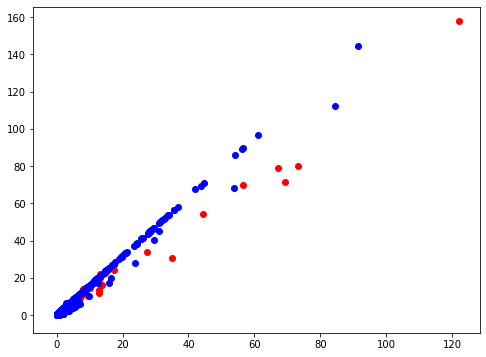

In [112]:
plt.figure(figsize=(8,6))

plt.scatter(X_2[y_train==1,0], X_2[y_train==1,1], c='red')
plt.scatter(X_2[y_train==0,0], X_2[y_train==0,1], c='blue')
#plt.ylim(-2, 2500)

## Raw

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
X = pd.read_hdf('../data/raw_X_train_1_to_4.hdf').values
y = pd.read_csv('../processed-data/y_train.csv', index_col=0).values[:X.shape[0]]

In [8]:
X.shape, y.shape

((79753, 6000), (79753, 1))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
%reset_selective '^X$'

Once deleted, variables cannot be recovered. Proceed (y/[n])?   y


In [20]:
%reset_selective '^y$'

Once deleted, variables cannot be recovered. Proceed (y/[n])?   y


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6000, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 750)
        self.fc4 = nn.Linear(750, 100)
        self.fc5 = nn.Linear(100, 10)
        self.fc6 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [9]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):
    torch_inputs = torch.from_numpy(features)
    torch_outputs = torch.from_numpy(labels)
    
    for epoch in range(num_epoch):
        # TODO: Step 1 - create torch variables corresponding to features and labels
        # TODO: Step 2 - compute model predictions and loss
        torch_pred = model(torch_inputs)
        loss = lossfunc(torch_pred, torch_outputs)
        # TODO: Step 3 - do a backward pass and a gradient update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 5 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss))

In [10]:
# create your optimizer
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#lossfunc = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([0.001, 1.0], dtype=np.float32)))
lossfunc = torch.nn.MSELoss()

train(features = X.astype(np.float32)[:10000],
      labels = y.astype(np.float32)[:10000],
      model = model,
      lossfunc = lossfunc, 
      optimizer = optimizer,
      num_epoch = 50)

Epoch [1/50], Loss: 1307.6654
Epoch [6/50], Loss: 0.0235
Epoch [11/50], Loss: 0.0201
Epoch [16/50], Loss: 0.0183
Epoch [21/50], Loss: 0.0173
Epoch [26/50], Loss: 0.0166
Epoch [31/50], Loss: 0.0163
Epoch [36/50], Loss: 0.0160
Epoch [41/50], Loss: 0.0159
Epoch [46/50], Loss: 0.0158


In [12]:
pred_train = model.forward(torch.from_numpy(X.astype(np.float32)[:10000]))
pred_test = model.forward(torch.from_numpy(X.astype(np.float32)[-5000:]))

In [21]:
(pred_test>0.1060).sum()

tensor(5000)

In [16]:
show_accuracy(y[:10000], pred_train.detach().numpy(), "Train")
show_accuracy(y[-5000:], pred_test.detach().numpy(), "Test")

Predicted earthquakes: 57


ValueError: Classification metrics can't handle a mix of continuous and binary targets